# CASE CAP GEMINI INVENT

**Objectifs de l'étude**

- Dans une première partie nous allons devoir construire un dataset pertinent (capgemini.csv) qui nous permettra dans la suite de mettre en place un modèle de machine learning, cette étape incluera du feature engineering
- Dans un second temps nous mettrons en place un ou plusieurs modèles de machine learning et évaluerons leurs performances, l'objectif du modèle devra être de prédire avec le plus de précision possible la **valeur foncière** d'un bien en fonction de certaines caractéristiques à déterminer 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from EDA_tools import DfAnalysis, DataPreprocessing
from DimRed_plus import PCAAnalysis

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

## EDA

In [2]:
agence = pd.read_csv(r"data\agence.csv")
france = pd.read_csv(r"data\france.csv")
insee_commune = pd.read_csv(r"data\insee_commune.csv")
localisation_commune = pd.read_csv(r"data\localisation_commune.csv")


In [19]:
localisation_commune.columns

Index(['Code_commune_INSEE', 'Nom_commune', 'Code_postal', 'Ligne_5',
       'Libellé_d_acheminement', 'Libell_d_acheminement', 'coordonnees_gps'],
      dtype='object')

### Première partie 

Etudier le dataframe agence: L'agence opère sur 36 communes différentes dans la haute garonne, il ne sera donc pertinent de ne conserver que les 

Premières remarques sur les variables:
- `type_local`, `evaluation_agent` devront être encodées

In [3]:
agence.shape

(4000, 13)

In [4]:
agence.describe().loc[['mean', 'std', 'min', 'max']]

,valeur_fonciere,code_postal,surface_reelle_bati,surface_terrain,nombre_pieces_principales,agent,prixcible,prixvente_initial
mean,2.124442e+05,31320.197500,77.036250,280.131750,3.343750,4.511750,2.161692e+05,2.270006e+05
std,1.350077e+05,222.062297,42.930131,408.480567,1.555214,2.892914,1.379113e+05,1.448099e+05
min,2.200000e+04,31000.000000,12.000000,8.000000,1.000000,0.000000,2.400000e+04,2.500000e+04
max,1.500000e+06,31830.000000,385.000000,7432.000000,11.000000,9.000000,1.532000e+06,1.609000e+06


In [5]:
agence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_mutation              4000 non-null   object 
 1   valeur_fonciere            4000 non-null   float64
 2   code_postal                4000 non-null   int64  
 3   nom_commune                4000 non-null   object 
 4   id_parcelle                4000 non-null   object 
 5   type_local                 4000 non-null   object 
 6   surface_reelle_bati        4000 non-null   float64
 7   surface_terrain            4000 non-null   float64
 8   nombre_pieces_principales  4000 non-null   float64
 9   agent                      4000 non-null   int64  
 10  prixcible                  4000 non-null   int64  
 11  prixvente_initial          4000 non-null   int64  
 12  evaluation_agent           4000 non-null   object 
dtypes: float64(4), int64(4), object(5)
memory usage:

In [6]:
obj_cols = agence.select_dtypes(include='object').columns
types = agence[obj_cols].apply(lambda x: x.apply(type).unique())
types = pd.DataFrame(types.to_dict()).T
types.columns = ['Data Type']
types


,Data Type
date_mutation,<class 'str'>
nom_commune,<class 'str'>
id_parcelle,<class 'str'>
type_local,<class 'str'>
evaluation_agent,<class 'str'>


In [12]:
agence['date_mutation'] = pd.to_datetime(agence['date_mutation'], format='%Y-%m-%d')
agence_new = agence.drop(['id_parcelle','code_postal','date_mutation','prixcible','prixvente_initial'], axis=1)
agence_new.columns


Index(['valeur_fonciere', 'nom_commune', 'type_local', 'surface_reelle_bati',
       'surface_terrain', 'nombre_pieces_principales', 'agent',
       'evaluation_agent'],
      dtype='object')

In [20]:
pre_agence = DataPreprocessing(agence_new)
pre_agence.scale_selected_columns()
X = pre_agence.scaled_df.drop('nom_commune', axis=1)
y = pre_agence.scaled_df['nom_commune']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   valeur_fonciere            4000 non-null   float64
 1   surface_reelle_bati        4000 non-null   float64
 2   surface_terrain            4000 non-null   float64
 3   nombre_pieces_principales  4000 non-null   float64
 4   agent                      4000 non-null   int64  
 5   type_local                 4000 non-null   object 
 6   evaluation_agent           4000 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 218.9+ KB


Le dataframe est 

on va surtout utiliser communes parce que pas de données dans les communes (du type placement dans la commune) et géoloc,pour ne pas faire exploser la dimensionnalité, on créera deux colonnes longitude et latitude pour situer les villes, voire ne garder qu'une seule des deux puisque les villes considérées doivent (je suppose) toutes avoir une des deux coordonnées diff, cela revient à procéder à des embeddings

Même si code postal prend en compte la ville de facon numérique ce n'est pas une variable qui prend intrinsèquement en compte les distances géographiques entre villes et ce n'est pas une variable continue, on peut donc retirer code postal et id commune pour le df de ML

la date de mutation 

on prendra france localisation et insee commune
insee commune permettra d'extrapoler aux villes pour lesquelles il n'y a pas eu de ventes 

In [9]:
encoder = LabelEncoder()
agence['nom_commune'] = encoder.fit_transform(agence['nom_commune'])
agence = agence.rename(columns={'nom_commune': 'id_commune'})

agence


,date_mutation,valeur_fonciere,code_postal,id_commune,type_local,surface_reelle_bati,surface_terrain,nombre_pieces_principales,agent,prixcible,prixvente_initial,evaluation_agent
0,2014-01-03,210000.0,31000,33,Appartement,70.0,70.0,3.0,1,206000,216000,Renove
1,2014-02-07,162500.0,31500,33,Appartement,67.0,67.0,3.0,1,155000,163000,Ancien
2,2014-02-18,381000.0,31200,33,Appartement,100.0,100.0,4.0,1,391000,411000,Renove
3,2014-02-24,159900.0,31200,33,Appartement,57.0,57.0,3.0,1,170000,178000,Renove
4,2014-02-26,58000.0,31100,33,Appartement,34.0,34.0,2.0,1,62000,65000,Ancien
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2017-07-13,140000.0,31600,27,Appartement,100.0,100.0,4.0,2,150000,158000,Ancien
3996,2017-04-14,108500.0,31600,8,Appartement,64.0,64.0,3.0,5,111000,117000,Ancien
3997,2018-01-27,90000.0,31600,8,Appartement,52.0,52.0,3.0,8,86000,90000,Renove
3998,2017-07-27,204900.0,31700,0,Appartement,81.0,81.0,4.0,5,209000,219000,Ancien


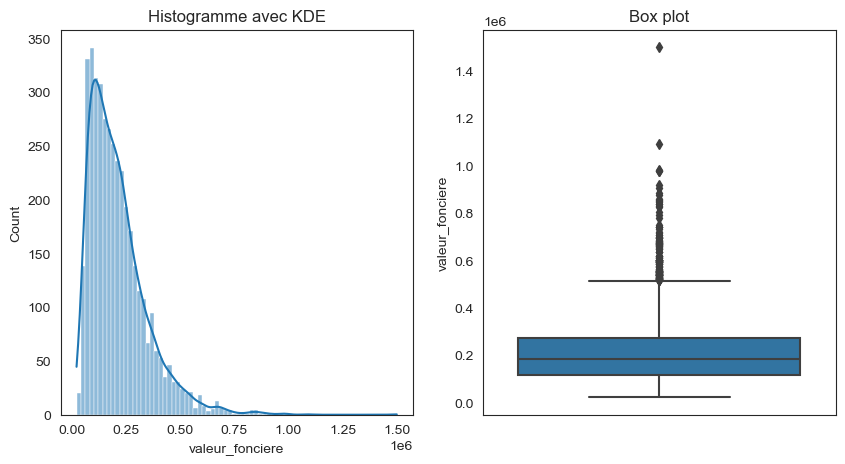

In [10]:

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

sns.histplot(data=agence, x='valeur_fonciere', kde=True, ax=ax1)
ax1.set_title('Histogramme avec KDE')

sns.boxplot(data=agence, y='valeur_fonciere', ax=ax2)
ax2.set_title('Box plot')

plt.show()


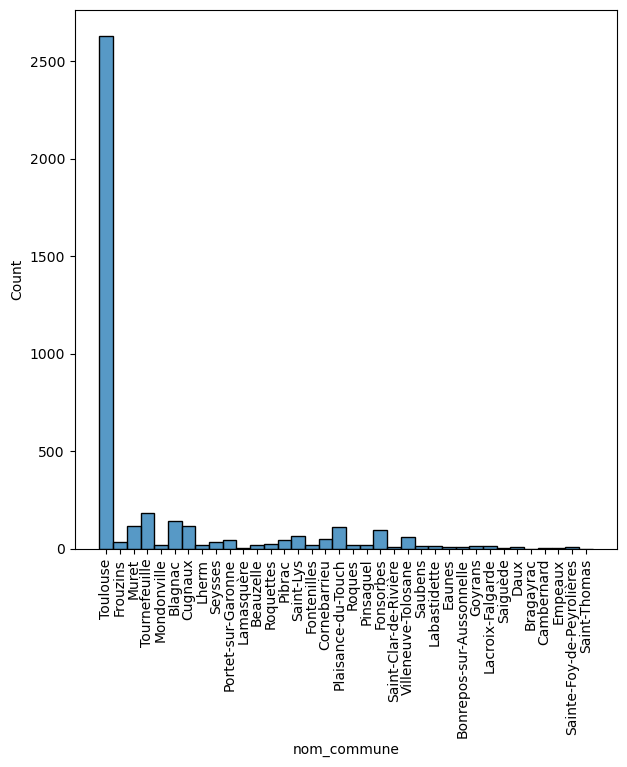

In [26]:
fig = plt.figure(figsize=(7,7))
sns.histplot(data=agence, x='nom_commune')
plt.xticks(rotation=90)

plt.show()

prendre toutes les villes de la haute garonne dans france et récupérer leurs coordonnées 
ajouter distance au centre ville de toulouse: Coordonnées GPS du centre-ville de Toulouse : Lat 43.603, Lon 1.443
au lieu d'utiliser la localisation exacte des adresses je vais utiliser les données du carreau naturel ie 

principalement: Ind_snv : Somme des niveaux de vie winsorisés des individus (ind snv), carreau ind, carreau men, carreau surf, carreau men prop (les menages proprio), carreau I pauv, log soc (logement sociaux), men coll (ménages en log collectifs), men_mais (menage en maison) et (Log_av45 : Nombre de logements construits avant 1945
Log_45_70 : Nombre de logements construits entre 1945 et 1969
Log_70_90 : Nombre de logements construits entre 1970 et 1989
Log_ap90 : Nombre de logements construits depuis 1990), et date mutation qui est la date de la vente



In [11]:
france.columns

Index(['date_mutation', 'valeur_fonciere', 'adresse_code_voie', 'code_postal',
       'nom_commune', 'code_commune', 'id_parcelle', 'type_local',
       'surface_reelle_bati', 'surface_terrain', 'nombre_pieces_principales',
       'longitude', 'latitude', 'departement', 'index_right',
       'carreau_Id_carr_n', 'carreau_Ind', 'carreau_Men', 'carreau_Men_pauv',
       'carreau_Men_1ind', 'carreau_Men_5ind', 'carreau_Men_prop',
       'carreau_Men_fmp', 'carreau_Ind_snv', 'carreau_Men_surf',
       'carreau_Men_coll', 'carreau_Men_mais', 'carreau_Log_av45',
       'carreau_Log_45_70', 'carreau_Log_70_90', 'carreau_Log_ap90',
       'carreau_Log_inc', 'carreau_Log_soc', 'carreau_Ind_0_3',
       'carreau_Ind_4_5', 'carreau_Ind_6_10', 'carreau_Ind_11_17',
       'carreau_Ind_18_24', 'carreau_Ind_25_39', 'carreau_Ind_40_54',
       'carreau_Ind_55_64', 'carreau_Ind_65_79', 'carreau_Ind_80p',
       'carreau_Ind_inc', 'carreau_I_pauv', 'carreau_t_maille'],
      dtype='object')

In [12]:
france['code_postal'] = france['code_postal'].astype(str)
ventes_HG = france[france['code_postal'].str.startswith('31')]
ventes_HG = ventes_HG.loc[:, ['date_mutation', 'valeur_fonciere', 'type_local',
            'surface_reelle_bati', 'surface_terrain', 'nombre_pieces_principales',
            'longitude', 'latitude','carreau_Ind', 'carreau_Men', 'carreau_Men_pauv',
            'carreau_Men_prop', 'carreau_Ind_snv', 'carreau_Men_surf',
            'carreau_Men_coll', 'carreau_Men_mais', 'carreau_Log_av45',
            'carreau_Log_45_70', 'carreau_Log_70_90', 'carreau_Log_ap90',
            'carreau_Log_inc', 'carreau_Log_soc']]

In [13]:
ventes_HG['date_mutation'] = pd.to_datetime(ventes_HG['date_mutation'], format='%Y-%m-%d')
ventes_HG = pd.get_dummies(ventes_HG, columns=['type_local'], drop_first=True)

In [15]:
analysis_ventes_HG = DfAnalysis(ventes_HG)
analysis_ventes_HG.duplicate_check()
analysis_ventes_HG.missing_values_check()
analysis_ventes_HG.correlation_matrix()

No duplicated rows
57661 row(s) have 0 missing values
Total number of rows with missing values: 0
List of indexes of rows with missing values: []


Maintenant on peut s'occuper de se débarasser des colonnes redondantes, trop corrélées à d'autres, on va plutot les combiner avec une pca, il faut d'abord normaliser nos variables

In [16]:
ventes_HG.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57661 entries, 42517 to 2640488
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date_mutation              57661 non-null  datetime64[ns]
 1   valeur_fonciere            57661 non-null  float64       
 2   surface_reelle_bati        57661 non-null  float64       
 3   surface_terrain            57661 non-null  float64       
 4   nombre_pieces_principales  57661 non-null  float64       
 5   longitude                  57661 non-null  float64       
 6   latitude                   57661 non-null  float64       
 7   carreau_Ind                57661 non-null  float64       
 8   carreau_Men                57661 non-null  float64       
 9   carreau_Men_pauv           57661 non-null  float64       
 10  carreau_Men_prop           57661 non-null  float64       
 11  carreau_Ind_snv            57661 non-null  float64       
 12  car

In [17]:
# Étape 1: Prétraitement des données

columns_to_exclude = ['date_mutation', 'type_local_Maison']
# Initialisez la classe en passant le DataFrame et les colonnes à exclure
preprocessor = DataPreprocessing(ventes_HG, columns_to_exclude)
# Appliquez la mise à l'échelle
ventes_HG_scaled_df = preprocessor.scale_selected_columns()

# Étape 2: Division des données

X_train, X_test, y_train, y_test = preprocessor.split_data('valeur_fonciere')




AttributeError: 'DataPreprocessing' object has no attribute 'scale_df'

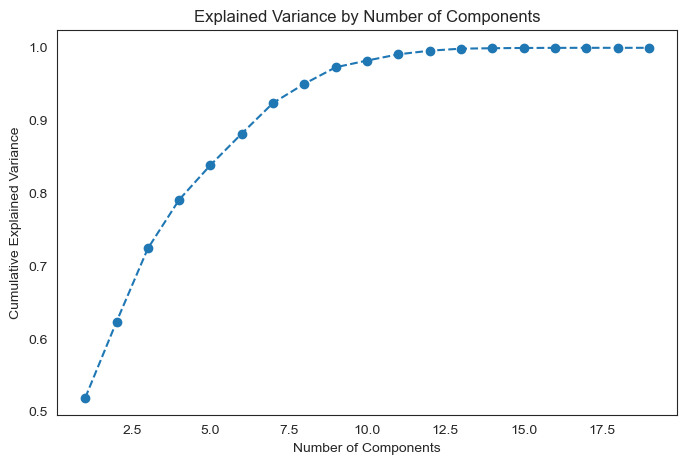

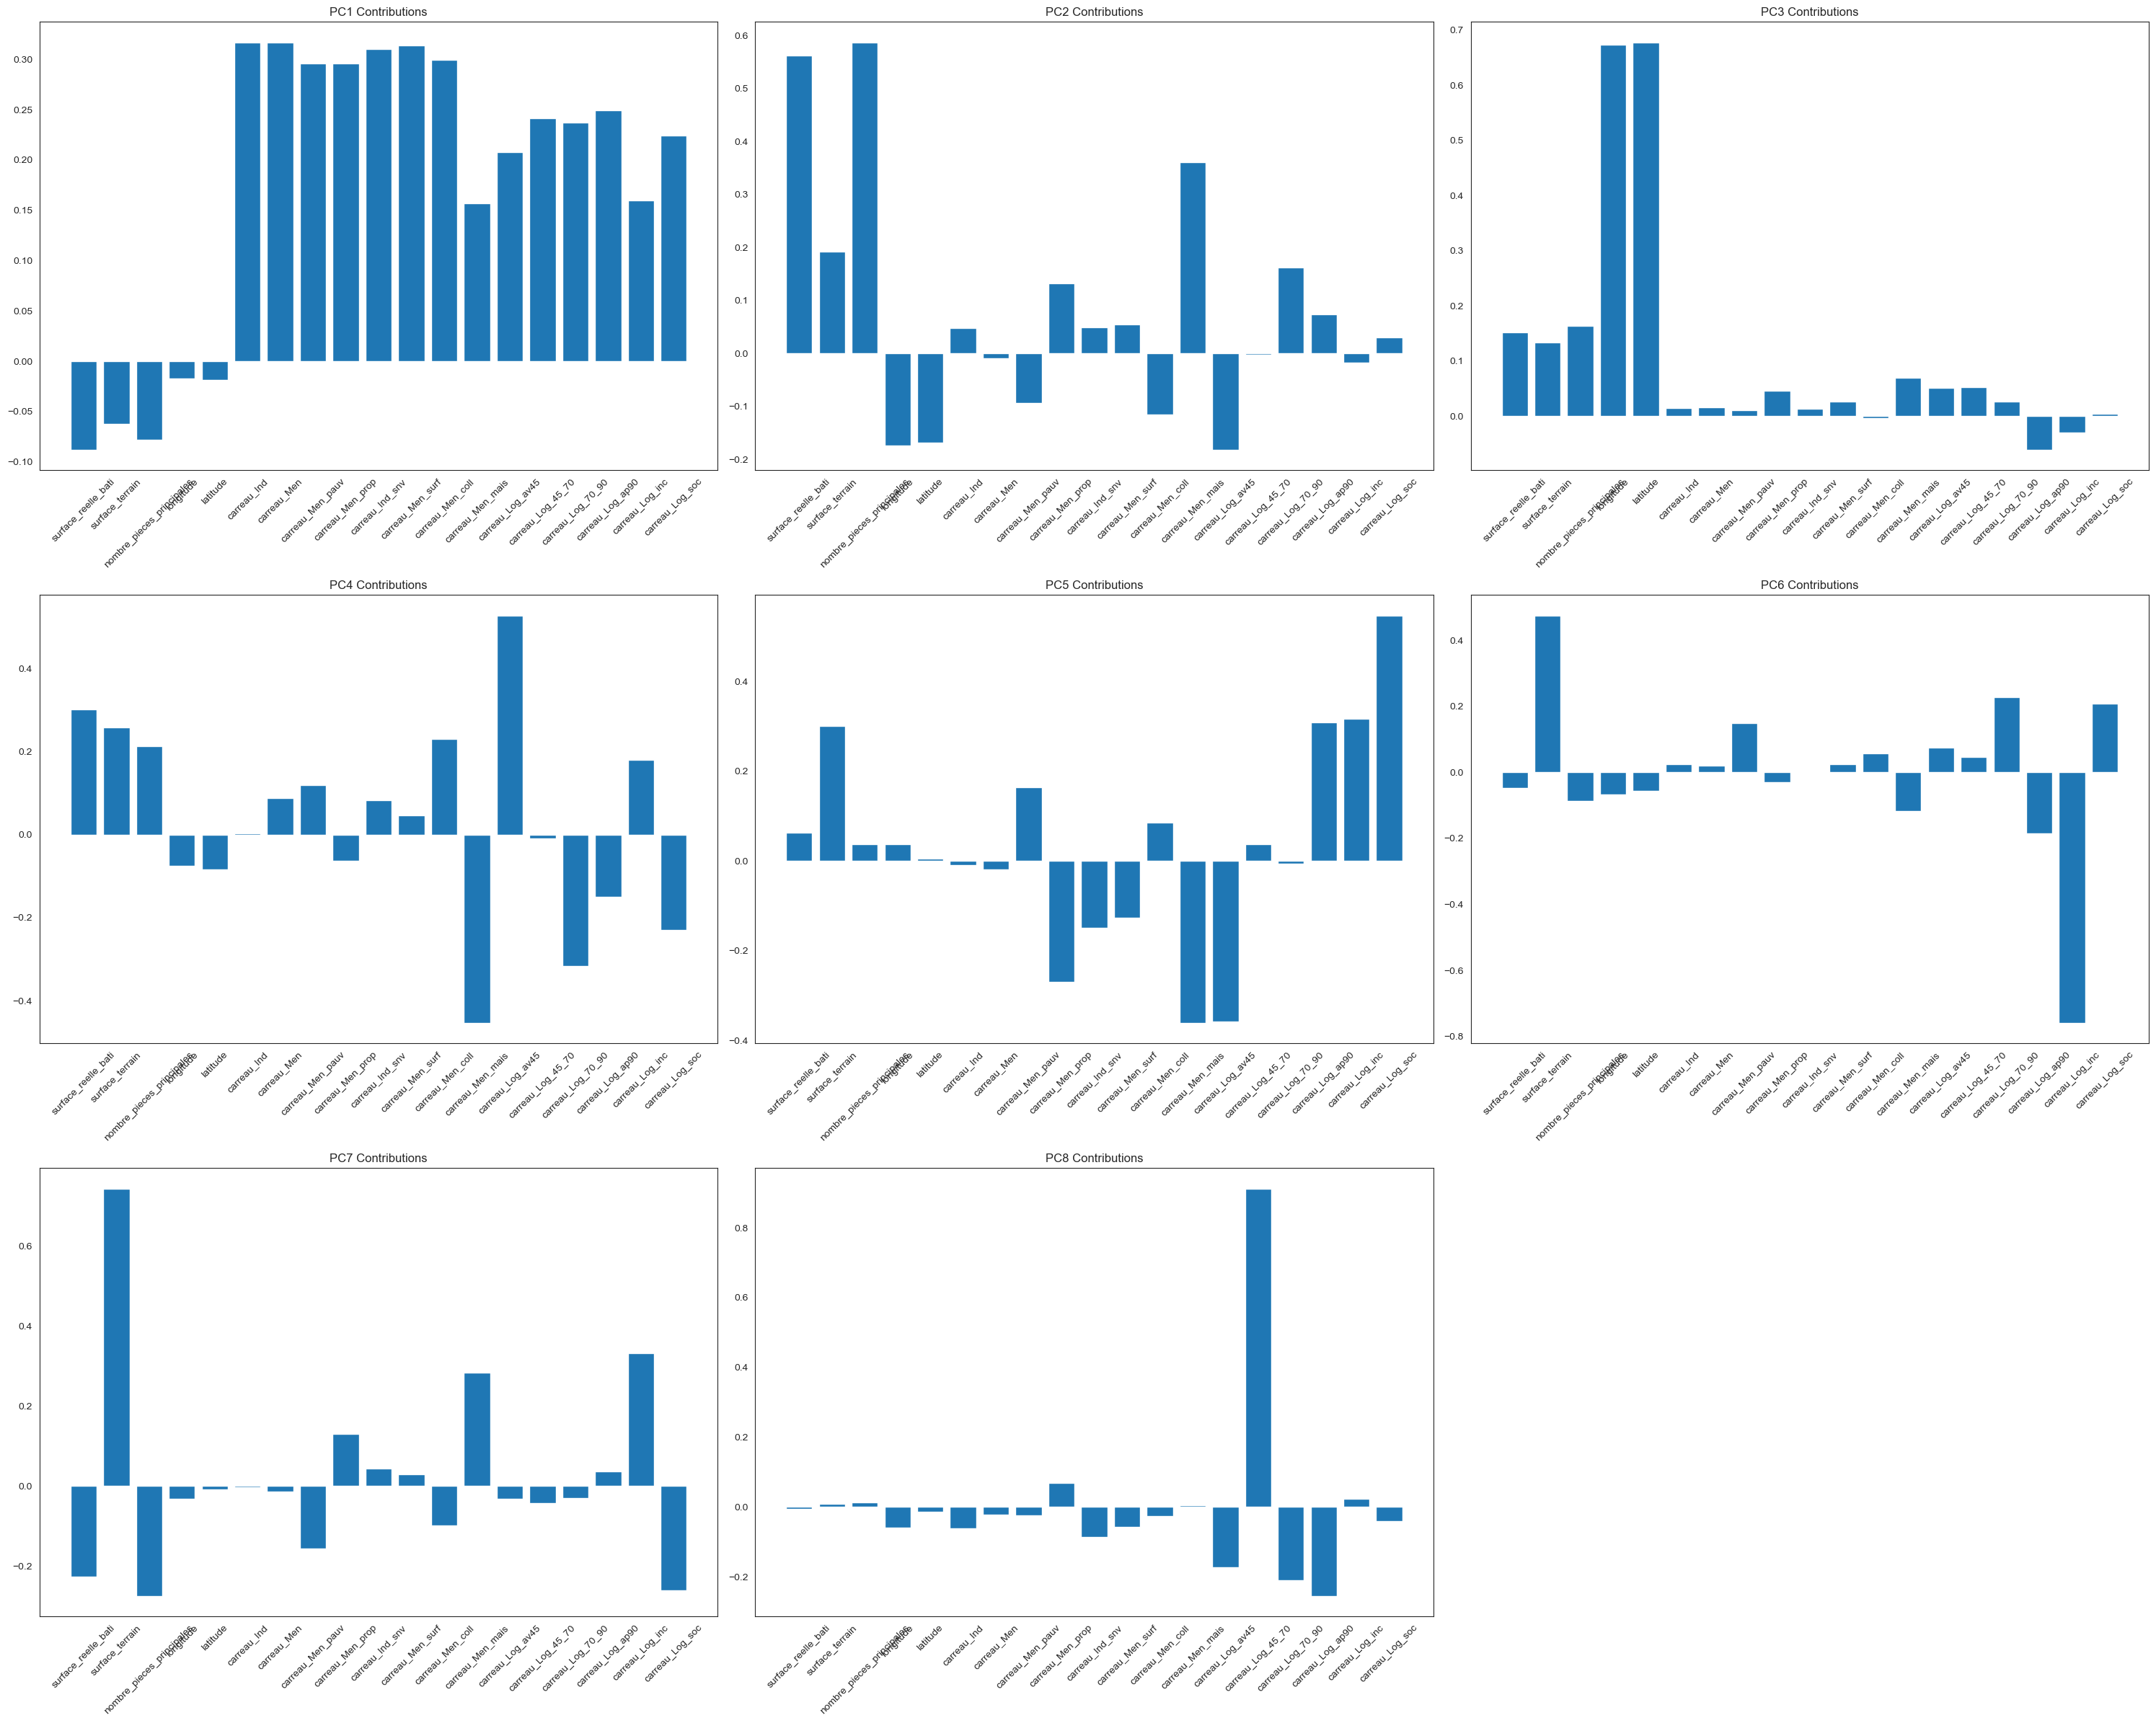

In [ ]:
# Étape 3: Application de PCA et analyse

# Appliquez PCA pour sélectionner le nombre de composants, cette fois sur les données d'entraînement
n_components = preprocessor.select_n_components(X_train)
# Instanciez PCA avec le nombre de composants déterminé
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)

pca_analysis = PCAAnalysis(pca.components_, feature_names=X_train.columns, pca=pca)

# Affichage des contributions des composants
fig, axs = pca_analysis.plot_pca_components_contributions()
# Affichage des scores PCA, optionnellement avec 'y_train' pour la coloration
pca_analysis.plot_scores(X_train, y_train)
# Affichage du cercle de corrélation
pca_analysis.plot_correlation_circle()

In [ ]:
anl_ventes_HG_scaled_df = DfAnalysis(ventes_HG_scaled_df)
anl_ventes_HG_scaled_df.identify_outliers()

,Percentage of Outliers
Column,
valeur_fonciere,0.667696
surface_reelle_bati,1.130747
surface_terrain,0.660759
nombre_pieces_principales,0.313904
longitude,2.974281
latitude,6.298885
carreau_Ind,1.838331
carreau_Men,2.873693
carreau_Men_pauv,3.067932
